In [1]:
import os
import yaml
from IPython.display import Image
import json
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

/home/roma/5sem/Real-time_Number_Plate_Recognition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_version = 11 # 5 or 11
output_csv_name = 'transformer_ocr'

In [3]:
project_dir = os.path.dirname(os.getcwd())
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
output_location = os.path.join(project_dir, 'data', f'yolo_v{model_version}')
output_name = 'detection_results'

input_img_dir = dataset_location
input_txt_dir = f"{output_location}/{output_name}/labels"
output_dir = f'{output_location}/cropped_plates'


os.makedirs(output_dir, exist_ok=True)

In [4]:
source_dataset_location = dataset_location
cropped_dataset_location = output_dir
results_dir = f"{output_location}/ocr_results"
scale_dataset_location = f"{output_location}/scaled_plates"

os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

In [5]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [6]:
for img_file in tqdm(os.listdir(cropped_dataset_location), desc='OCR'):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        # Save the processed image
        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        image = Image.open(output_path)

        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)

        txt = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'json')
        with open(output_txt_path, 'w') as f:
            dict_lst = [{'Text' : txt, 'Probability' : 100}]
            json.dump(dict_lst, f)


OCR:   0%|          | 0/386 [00:00<?, ?it/s]/home/roma/5sem/Real-time_Number_Plate_Recognition/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
OCR: 100%|██████████| 386/386 [00:38<00:00,  9.92it/s]


In [7]:
df_true_location = f'{dataset_location}/output.csv'
df_true = pd.read_csv(df_true_location)
df_true['picture_name'] = df_true['picture_name'].apply(lambda x: 'plate_'+x)
df_true.set_index('picture_name', inplace=True)
df_true.head()

,text
picture_name,
plate_00808.jpg,046TS
plate_01433.jpg,912FB
plate_01063.jpg,044FF
plate_01576.jpg,M496T
plate_00263.jpg,155DW


In [8]:
df_pred_location = f'{output_location}/{output_csv_name}_pred.csv'
plate_numbers = []
plate_strings = []

threshold = 0.6

for ocr_file in os.listdir(results_dir):
    with open(os.path.join(results_dir, ocr_file), 'r') as f:
        plt_str = ''
        results = json.load(f)
        for result in results:
            if float(result['Probability']) > threshold:
                plt_str += result['Text']
        plt_str = plt_str.replace(" ", "").upper()
        plate_strings.append(plt_str)
        plate_numbers.append(ocr_file.split('.')[0]+'.jpg')

df_pred = pd.DataFrame({'picture_name':plate_numbers, 'text':plate_strings})
df_pred.to_csv(df_pred_location)
df_pred.set_index('picture_name', inplace=True)
df_pred.head()

,text
picture_name,
plate_01772.jpg,1934AND
plate_00694.jpg,1238.BG.
plate_00978.jpg,019-792
plate_01461.jpg,"""#"
plate_00857.jpg,"""1659THY."


In [9]:
import pandas as pd
from difflib import SequenceMatcher
from sklearn.metrics import f1_score, precision_score, recall_score

# Merging dataframes on 'picture_name' index to only evaluate overlapping entries
df_merged = df_true.join(df_pred, lsuffix='_true', rsuffix='_pred', how='inner')

# 1. Accuracy (Exact Match)
exact_matches = (df_merged['text_true'] == df_merged['text_pred']).sum()
accuracy = exact_matches / len(df_merged)

# 2. Levenshtein Distance (Edit Distance) - Using SequenceMatcher
def levenshtein_ratio(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

df_merged['levenshtein_ratio'] = df_merged.apply(lambda row: levenshtein_ratio(row['text_true'], row['text_pred']), axis=1)
average_levenshtein_ratio = df_merged['levenshtein_ratio'].mean()

# 3. Character-Level Precision, Recall, F1 Score
def calculate_char_level_scores(true_text, pred_text):
    # Creating sets of characters for precision, recall, F1
    true_chars = set(true_text)
    pred_chars = set(pred_text)
    
    true_positive = len(true_chars & pred_chars)
    precision = true_positive / len(pred_chars) if pred_chars else 0
    recall = true_positive / len(true_chars) if true_chars else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Calculate character-level scores for each entry
df_merged[['char_precision', 'char_recall', 'char_f1']] = df_merged.apply(
    lambda row: pd.Series(calculate_char_level_scores(row['text_true'], row['text_pred'])), axis=1
)

# Aggregate the results
average_precision = df_merged['char_precision'].mean()
average_recall = df_merged['char_recall'].mean()
average_f1_score = df_merged['char_f1'].mean()

# Output results
print(f"Accuracy (Exact Match): {accuracy:.2f}")
print(f"Average Levenshtein Ratio: {average_levenshtein_ratio:.2f}")
print(f"Character-Level Precision: {average_precision:.2f}")
print(f"Character-Level Recall: {average_recall:.2f}")
print(f"Character-Level F1 Score: {average_f1_score:.2f}")

df_merged_loaction = f'{output_location}/merged.csv'
df_merged.to_csv(df_merged_loaction)


Accuracy (Exact Match): 0.00
Average Levenshtein Ratio: 0.43
Character-Level Precision: 0.41
Character-Level Recall: 0.55
Character-Level F1 Score: 0.46


{'Text': 'to control', 'Probability': 100}


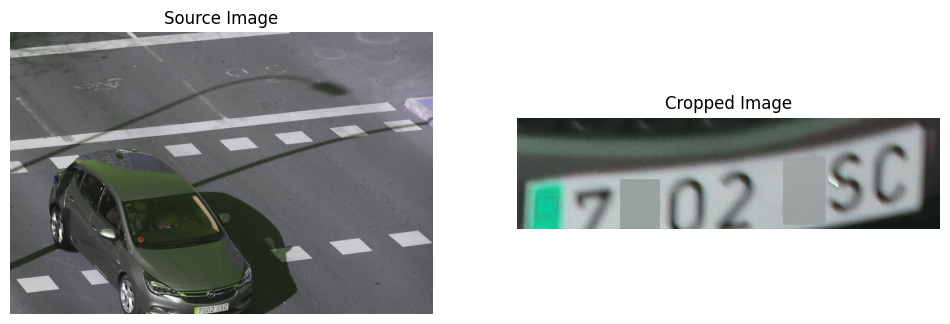

{'Text': 'sutton .', 'Probability': 100}


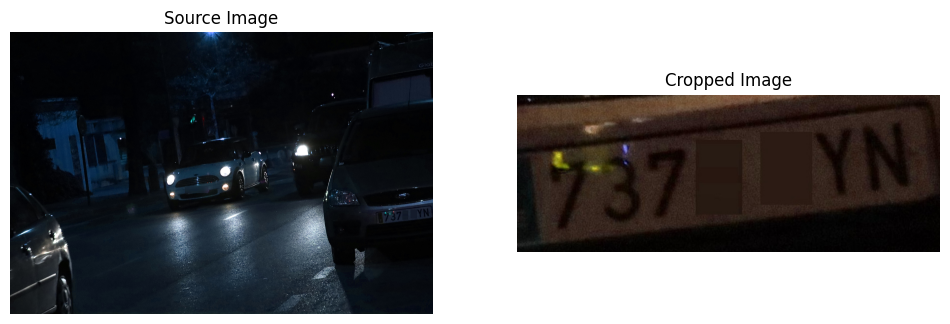

{'Text': '( 18.18 ( J.', 'Probability': 100}


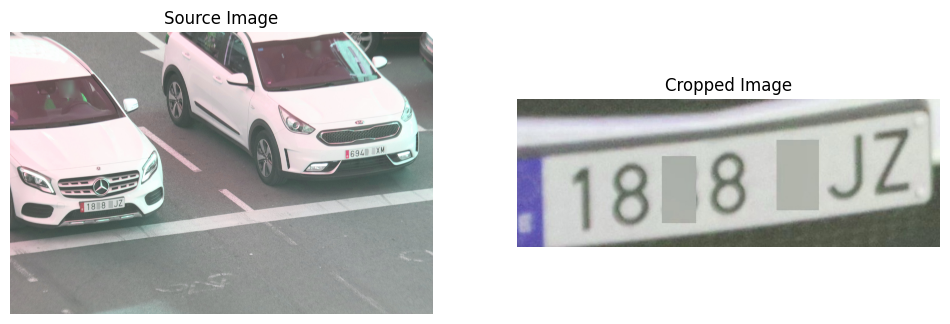

{'Text': 'microbiology', 'Probability': 100}


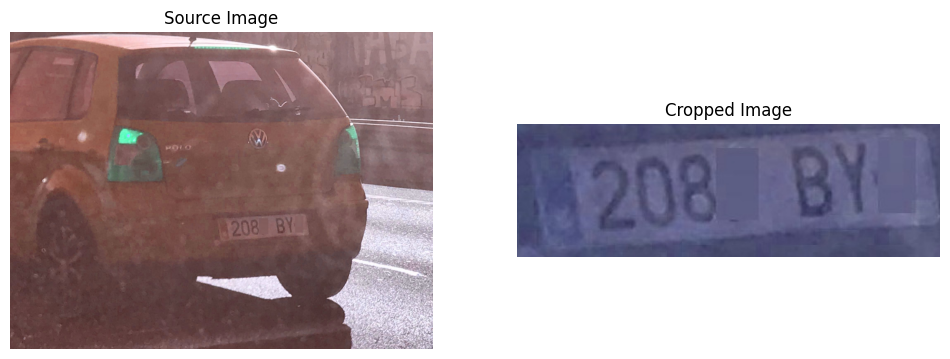

{'Text': '43. 3/95.55', 'Probability': 100}


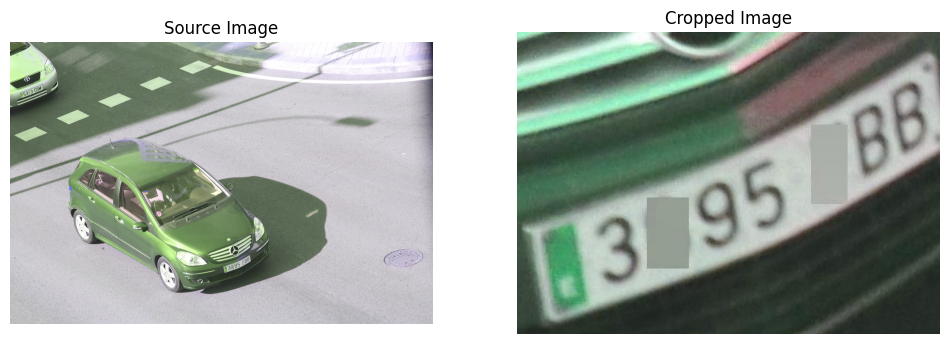

{'Text': 'UM 28 62 .', 'Probability': 100}


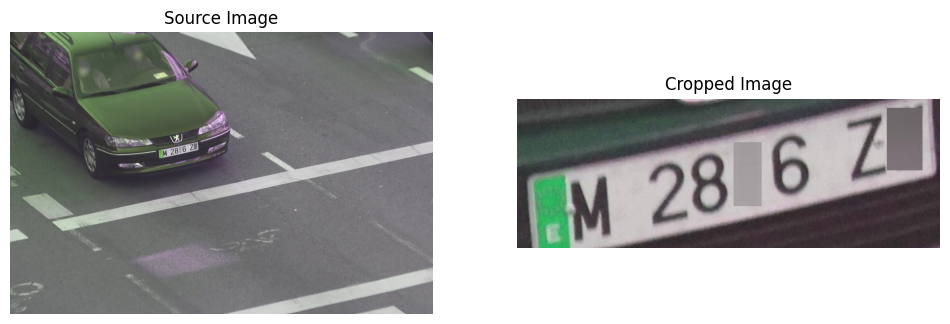

{'Text': '1976 ,', 'Probability': 100}


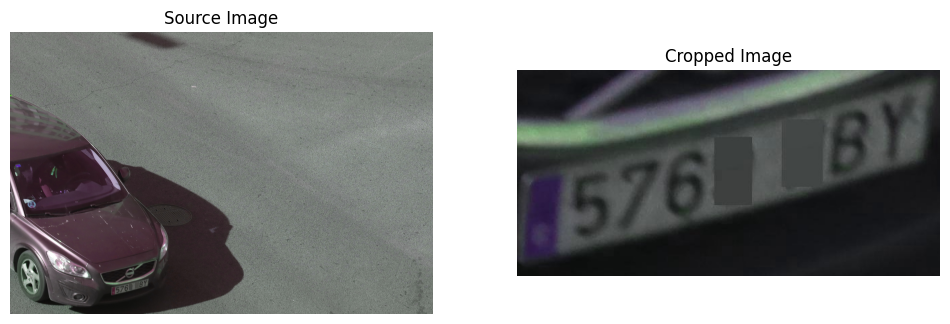

{'Text': 'leopathy .', 'Probability': 100}


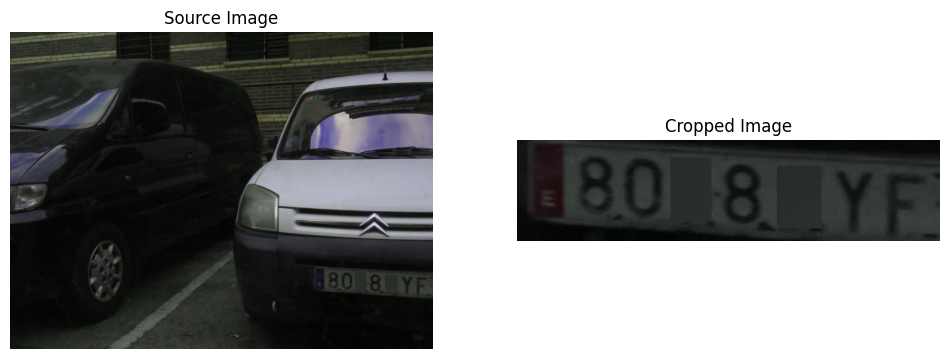

{'Text': 'B 287-SJ.', 'Probability': 100}


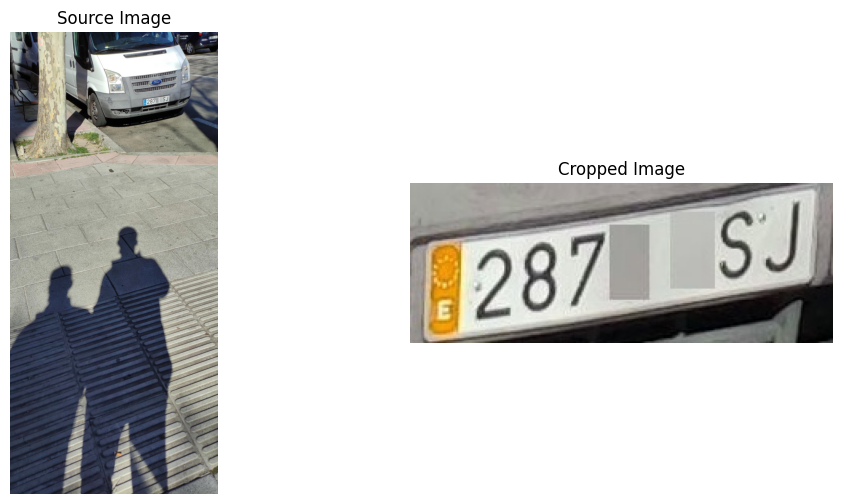

{'Text': 'no agree', 'Probability': 100}


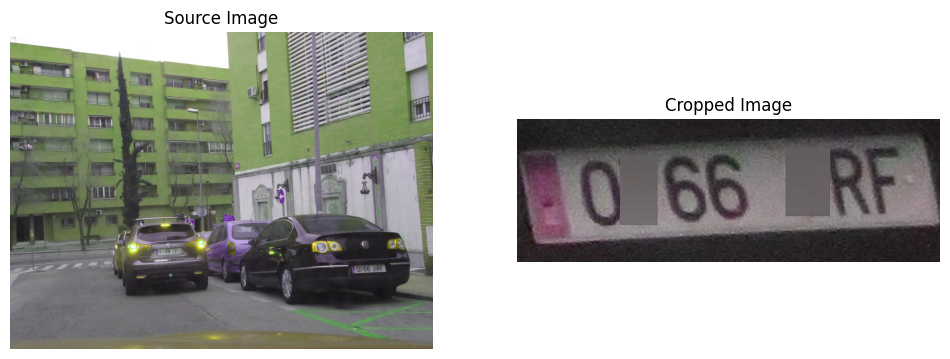

In [10]:
import random

first_dataset = source_dataset_location
second_dataset = scale_dataset_location

# start_index = 0
start_index = random.randint(0, len(os.listdir(second_dataset)))

for img_file in os.listdir(second_dataset)[start_index:start_index+10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'json')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = json.load(f)
            for result in results:
                print(result)
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.show()